### Querying the data

The data provided came from the sources listed below:
  1.Box Office Mojo
  2.IMDB
  3.Rotten Tomatoes
  4.TheMovieDB
  5.The Numbers
  
Our first task is to import and inspect the data. We start off with IMDB, which is in SQL format

In [529]:
# import the required modules
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [530]:
# open up a connection
conn = sqlite3.connect('im.db')

# initialize a cursor
cur = conn.cursor()

### Table Names

Below we inspect the database to get an overview of the tables contained

In [531]:
table_name_query = """SELECT name 
                      AS 'Table Names' 
                      FROM sqlite_master 
                      WHERE type='table';"""

pd.read_sql(table_name_query, conn)

,Table Names
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


### Movie Ratings Table
We'll start with exploring the movie_ratings table. The table has no missing values, and the movie_id column has no duplicates.

In [532]:
ratings = """SELECT * 
                      FROM movie_ratings;"""

df_ratings = pd.read_sql(ratings, conn)

# check columns with missing data
print("columns with missing values")
print(df_ratings.isnull().any())
print('\n')

# check columns with duplicated data
print("columns with duplicates")
for output in [df_ratings[col].duplicated().value_counts() for col in df_ratings.columns]:
    print('\n')
    print(output)

print('\n')
print(f'df_ratings has {df_ratings.shape[0]} rows & {df_ratings.shape[1]} columns')

df_ratings.head()

columns with missing values
movie_id         False
averagerating    False
numvotes         False
dtype: bool


columns with duplicates


False    73856
Name: movie_id, dtype: int64


True     73765
False       91
Name: averagerating, dtype: int64


True     66507
False     7349
Name: numvotes, dtype: int64


df_ratings has 73856 rows & 3 columns


,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


In [533]:
df_ratings.describe()

,averagerating,numvotes
count,73856.000000,7.385600e+04
mean,6.332729,3.523662e+03
std,1.474978,3.029402e+04
min,1.000000,5.000000e+00
25%,5.500000,1.400000e+01
50%,6.500000,4.900000e+01
75%,7.400000,2.820000e+02
max,10.000000,1.841066e+06


### Check for Outliers
A simple look at the boxplot of movie rating and number of votes shows that we have some outliers. However, a scatterplot of the relationship between these 2 variables show that there is a very weak linear relationship between number of votes cast and the movie rating received. I therefore argue that these outliers are naturally occurring and should therefore not be removed

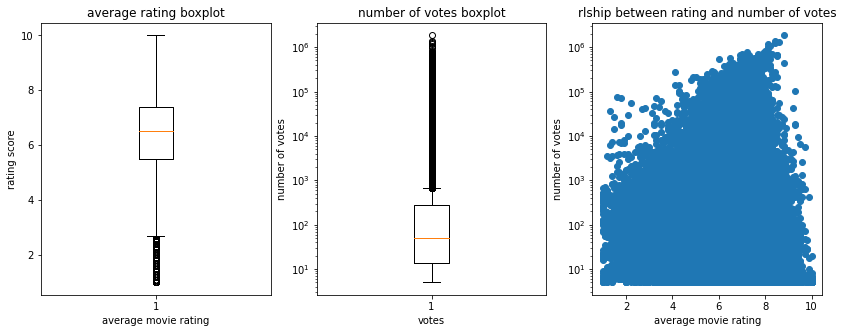

In [534]:
fig, axes = plt.subplots(figsize=(14, 5), ncols=3)

# boxplot to check average rating
axes[0].boxplot(df_ratings.averagerating)
axes[0].set_title('average rating boxplot')
axes[0].set_xlabel('average movie rating')
axes[0].set_ylabel('rating score')

# boxplot to check number of votes
axes[1].boxplot(df_ratings.numvotes)
axes[1].set_title('number of votes boxplot')
axes[1].set_xlabel('votes')
axes[1].set_ylabel('number of votes')
axes[1].set_yscale('log')

# scatterplot to check relationship between rating &
# number of votes
axes[2].scatter(df_ratings.averagerating,df_ratings.numvotes)
axes[2].set_title('rlship between rating and number of votes')
axes[2].set_xlabel('average movie rating')
axes[2].set_ylabel('number of votes')
axes[2].set_yscale('log');


### Join Movie Ratings Table to Movie Basics table
Movie basics is one of the crucial tables since it shows since it shows the properties of each movie like title, year, runtime and genre. It has 146144 rows and 6 columns.

To work efficiently, I will innerjoin these two tables to shed off any movies that don't have ratings. This is because movies with no ratings have no usable metrics to analyse perforamance. So that when we start to clean the movie bascis variables we will have shed off any unnecessary data

The Movie basics table has unique movie ids. Thus it is safe to join the 2 tables on this metric before we start cleaning

In [535]:
m_basics_rate = """
SELECT *
   FROM movie_basics
  JOIN movie_ratings
  USING (movie_id);
"""

dfm_basics_rate = pd.read_sql(m_basics_rate, conn)

print(dfm_basics_rate.shape)
dfm_basics_rate.head()

(73856, 8)


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


### Check Joined Table Properties
The data has some missing values in  "runtime_minutes" (10%) & "genres" (1%) columns

There are some duplicates worth exploring - primary titles (5%) & original titles (4%) columns. Since there are no entire row duplicates, and movie ids are unique, we need to ascetain whether these are different movies with the same name, different versions of the same movie or data error

In [536]:
# check for data properties
print(dfm_basics_rate.info())
print('\n')

# check for dataframe row duplicates
print('dataframe row duplicates')
print(dfm_basics_rate.duplicated().value_counts())
print('\n')

# check for col duplicates
print('row duplicates by column')
for output in [dfm_basics_rate[col].duplicated().value_counts() for col in dfm_basics_rate.columns]:
    print('\n')
    print(output)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB
None


dataframe row duplicates
False    73856
dtype: int64


row duplicates by column


False    73856
Name: movie_id, dtype: int64


False    69993
True      3863
Name: primary_title, dtype: int64


False    71097
True      2759
Name: original_title, dtype: int64


True     73846
False       10
Name: start_year, dtype: int64


True     73566
False      290
Name: run

### Check for Outliers

Before we dive into duplicates, we will check for outliers in start_year & runtime_minutes

start_year has no outliers with oldest movie producted in 2010, and the most recent in 2019. It should be noted that his only holds true for the filtered databse after the join, and would not have been the case for the full table on movie basics - which is beyond the scope of this analysis. 

The descriptive statistics below show a movie with a maximum runtime of 51,420 minutes. This translates to 178 days. A quick online search shows that the movie called [Logistics](https://www.google.com/search?client=firefox-b-d&q=logistics+2012&si=AEcPFx71Yi7YECiZ82vRWCw7NKNJMT9Iv-NFgCv51fzOTfFapqSRglP--7Ml843pwu4TClirYsk9nQZ5vKm6zkNQY-LBCxZaSwThcsS5NLg1T-U_m2vutE4%3D&ictx=1&ved=2ahUKEwjy6IPPnNL9AhUcX_EDHZszCkEQnZMFegQIXRAC#wptab=si:AEcPFx5m7Nylg00wpE-iI3fN8-AfSDNfZqA7NKPDMKmG1MgjOhCtz3XVxKdMdK29gG4M7YXdCjTNRNFsUMqV3SMWmlvjlhHM-z3RNd1kFbhuwYweFpTDZEVOentU3B2CeI65zAs0U_XoioMpIXWXzJKDMkvnZj8B2Q%3D%3D), is truly that long!

However, I feel that we need to clean up this variable, since we also have movies that run for 1 minute only. This however is unrealistic, and most likely due to the fact that they might have saved trailers in the database, rather than the whole movie.



In [537]:
dfm_basics_rate[['start_year', 'runtime_minutes']].describe()

,start_year,runtime_minutes
count,73856.000000,66236.000000
mean,2014.276132,94.654040
std,2.614807,208.574111
min,2010.000000,3.000000
25%,2012.000000,81.000000
50%,2014.000000,91.000000
75%,2016.000000,104.000000
max,2019.000000,51420.000000


Below I further investigate movie duration through visualisation. The first plot shows the distribution movie durations for each movie, with outliers at both the upper and lower bounds of the data. 

The second plot shows that most movies flucuate within 100 minute range, and that the movie length has no bearing on its rating. Despite this, it is impractical to have movies running for less than 10 minutes. As I result, I will use the boxplot iqr method to determine a realistic movie duration that should be used in the analysis

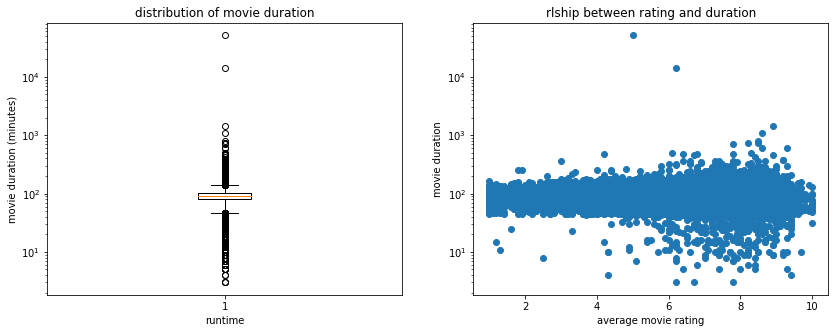

In [538]:
# visualise runtime and duration properties

fig, axes = plt.subplots(figsize=(14, 5), ncols=2)

# boxplot to check runtime
axes[0].boxplot(dfm_basics_rate.runtime_minutes.dropna())
axes[0].set_title('distribution of movie duration')
axes[0].set_xlabel('runtime')
axes[0].set_ylabel('movie duration (minutes)')
axes[0].set_yscale('log')

# scatterplot to check relationship between duration &
# rating
axes[1].scatter(dfm_basics_rate.averagerating,dfm_basics_rate.runtime_minutes)
axes[1].set_title('rlship between rating and duration')
axes[1].set_xlabel('average movie rating')
axes[1].set_ylabel('movie duration')
axes[1].set_yscale('log');


Below we use the boxplot method to identify the whiskers. Thus from below, any movie that runs for less than 46.5 minutes will be treated as a lower limit outlier.

The analysis also shows we should treat any movie above 138.5 minutes as the upper limit outlier. However, I will use 250 minutes as the upper limit outlier - given that successful movies like [Avatar 2](https://www.google.com/search?q=avatar%3A+the+way+of+water&client=firefox-b-d&sxsrf=AJOqlzVngEJ-oGMNGFPJKmHNCFTxl1TEHg%3A1678480975101&ei=T5YLZNDXBaCSxc8PtsSR4AY&gs_ssp=eJzj4tLP1TdIz03KNkw3YPSSSCxLLEksslIoyUhVKE-sVMhPA1IlqUUA6gcMnw&oq=ava&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQARgAMgQILhAnMgQIIxAnMgQIIxAnMgcILhCxAxBDMgQILhBDMgQILhBDMgQIABBDMgcILhDUAhBDMgcILhDUAhBDMggIABCABBCxAzoKCC4QxwEQ0QMQQzoLCC4QgwEQsQMQgAQ6CgguELEDENQCEENKBAhBGABQxRFY5hVgsCtoAHABeACAAbMDiAHeCpIBBzItMi4wLjKYAQCgAQHAAQE&sclient=gws-wiz-serp) and [Avengers: Endame](https://www.google.com/search?q=endgame&client=firefox-b-d&sxsrf=AJOqlzVb2kk7E1Qhi1tmZl4jpvanADbZ3Q%3A1678515114690&ei=qhsMZKTgKYmokdUP9YCykAs&gs_ssp=eJzj4tbP1TcwNDJLssguM2D0Yk_NS0lPzE0FAERaBng&oq=end&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQARgAMgoILhCxAxDUAhBDMgoILhDUAhCxAxBDMgQIABBDMgQIABBDMgoIABCxAxDJAxBDMggIABCABBCxAzIKCAAQgAQQFBCHAjIICAAQgAQQsQMyCwgAEIAEELEDEIMBMggIABCABBCxAzoHCC4QsAMQJzoKCAAQRxDWBBCwAzoECC4QJzoECCMQJzoECC4QQzoICC4QsQMQgwE6CAgAELEDEIMBOgcILhDUAhBDOgoIABCxAxCDARBDSgQIQRgAUN8JWIAMYPUhaAFwAXgAgAG9AogB_QaSAQUyLTEuMpgBAKABAcgBCcABAQ&sclient=gws-wiz-serp) clocked over 180 minutes. [Zack Snyder's Justice League](https://www.google.com/search?q=justice+league+snyder+cut&client=firefox-b-d&sxsrf=AJOqlzWALsP9vjqjjz9AyUA5Huk7Fc4FYg%3A1678514522943&ei=WhkMZKCSOZqakdUP-vG2yAI&gs_ssp=eJzj4tVP1zc0zDI0Mqg0TjMwYPSSzCotLslMTlXISU1ML01VKM6rTEktUkguLQEADL8NvQ&oq=justice+league+s&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQARgAMgQILhBDMgUILhCABDIFCAAQgAQyCAguEIAEENQCMgUIABCABDIFCAAQgAQyCAguEIAEENQCMgUIABCABDIFCAAQgAQyBQgAEIAEOgoIABBHENYEELADOgQIIxAnOgcILhDUAhBDOgQIABBDOgoILhCxAxCDARBDOgoILhCxAxDUAhBDOgoILhDHARDRAxBDOgcILhCxAxBDOgoIABCxAxCDARBDOgQIABADOgoIABCABBAUEIcCOgsIABCABBCxAxCDAToKCC4Q1AIQsQMQQzoFCAAQkQI6BQguEJECSgQIQRgAUPQHWLA_YKtZaAFwAXgAgAHiAogBmCGSAQYyLTE1LjGYAQCgAQHIAQjAAQE&sclient=gws-wiz-serp) was over 240 minutes long.

In [539]:
dfm_basics_rate[['start_year', 'runtime_minutes']].describe().runtime_minutes[6]

104.0

In [540]:
# use iqr from the boxplot to calculate outlier runtimes
q1 = dfm_basics_rate[['start_year', 'runtime_minutes']].describe().runtime_minutes[4]
q3 = dfm_basics_rate[['start_year', 'runtime_minutes']].describe().runtime_minutes[6]

iqr = q3 - q1
lower_whisk = q1 - (1.5*iqr)
upper_whisk = q3 + (1.5*iqr)
upper_count = dfm_basics_rate[dfm_basics_rate['runtime_minutes'] >= 250].shape[0]
lower_count = dfm_basics_rate[dfm_basics_rate['runtime_minutes'] <= 46.5].shape[0]

                              
print(f'lower bound: {lower_whisk}, upper bound: {upper_whisk}')
print(f'lower bound has {lower_count} which is {round(lower_count/73856, 3)}% of the data')
print(f'upper bound has {upper_count} which is {round(upper_count/73856, 3)}% of the data')

lower bound: 46.5, upper bound: 138.5
lower bound has 871 which is 0.012% of the data
upper bound has 74 which is 0.001% of the data


The code below thus removes any movie that is less than 46.5 minutes or greater than 250 minutes. Thus our sample reduces from 73,856 to 72,914.

In [541]:
# Remove outlier runtime
dfm_basics_rate = dfm_basics_rate[(dfm_basics_rate['runtime_minutes'].isnull()) | 
                              ((dfm_basics_rate['runtime_minutes'] >= 46.5) & 
                               (dfm_basics_rate['runtime_minutes'] <= 250))]

print(f'sample: {dfm_basics_rate.shape[0]} movies')
print("max_time  :", dfm_basics_rate.runtime_minutes.max())
print("min_time:", dfm_basics_rate.runtime_minutes.min())
dfm_basics_rate.head()

sample: 72914 movies
max_time  : 250.0
min_time: 47.0


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


### Investigating Duplicates in "primary_title" 
We need to make some consideration when looking at these duplicates:

1.titles may be duplicated because we have different movies with the same name. For example, in the output below, we have 2 movies with the name "100% Love". A quick Google search shows that the one produced in [2011](https://www.google.com/search?q=100+love&client=firefox-b-d&ei=85AMZJeCCofbkgXGuLTACg&gs_ssp=eJzj4tLP1TdIz7IsL0gyYPTiMDQwUMjJL0sFAEhtBk0&oq=100%25+love&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQARgGMgUIABCABDIFCC4QgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEMgQILhBDMgUIABCABDIFCAAQgAQyBAguEEM6CggAEEcQ1gQQsAM6BggAEBYQHjoICAAQFhAeEA86FggAEOoCELQCEIoDELcDENQDEOUCGAE6EwguEI8BEOoCELQCEIwDEOUCGAI6EwgAEI8BEOoCELQCEIwDEOUCGAI6BQgAEJECOgUILhCRAjoHCC4Q1AIQQzoRCC4QgAQQsQMQgwEQxwEQ0QM6CwgAEIAEELEDEIMBOggILhCxAxCDAToICC4Q1AIQkQI6CgguELEDENQCEEM6BwgAELEDEEM6BAgAEEM6BwguELEDEEM6CgguENQCELEDEEM6CggAELEDEIMBEEM6CAgAEIAEELEDOggIABCxAxCRAjoLCC4QgAQQsQMQgwE6CAguEIAEELEDOgUILhCxAzoICC4QsQMQkQJKBAhBGABQlRhY1NMDYIz3A2gHcAF4BIABswKIAfojkgEGMi0xOC4xmAEAoAEBsAETyAEIwAEB2gEECAEYB9oBBggCEAEYCg&sclient=gws-wiz-serp) is different from that in [2012](https://www.google.com/search?q=100+love+2012&client=firefox-b-d&ei=7xwMZMPxCpuEhbIPgKK9gAs&gs_ssp=eJzj4tLP1TfIMk5Ji08xYPTiNTQwUMjJL0tVMDIwNAIAZ18HDg&oq=100%25+love&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQARgJMgUIABCABDIFCC4QgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEMgUILhCABDIFCAAQgAQyBQgAEIAEMgQILhBDOhEILhCDARDHARCxAxDRAxCABDoLCAAQgAQQsQMQgwE6CAgAEIAEELEDOgsILhCABBCxAxCDAToICAAQsQMQgwE6BQguEJECOgcILhDUAhBDOggILhCABBCxAzoFCC4QsQNKBAhBGABQsxZYjjVgz6MBaABwAXgAgAGAAogB0RGSAQQyLTEwmAEAoAEBwAEB&sclient=gws-wiz-serp).
2.titles may be duplicated due to repition of the same movie name as in the case of [1989](https://www.google.com/search?client=firefox-b-d&sxsrf=AJOqlzU3nZFpP-IA_vBND1XKMbSsri616Q:1678543316627&q=1989&si=AEcPFx6vY0DhKadBB5SBEToMU9VHAhZfqDGw6RWqRSw7Z2ppKDiQdW4Vw7uSrw25sUtZ8ITFcRiymecpWMqDWxeNy_a9Gm_Spylsmbe9ucx4XEsQJcwM9jlDfkQK-mCSSSPWeKjlUiAOF9EHMPIBKtlkPOJSbZsHvq0nN-wFTSz8Vob0GXLFJQ0%3D&sa=X&ved=2ahUKEwjstYKRhdT9AhXpsKQKHdunCK4Q6RN6BAhIEAE&biw=1696&bih=829&dpr=1.13) which appears twice, with the same production year of 2014.

Due to the complexity of identifying these nuances, and given that only a small sample of 5% has more than one "primary_title" I will treat all as duplicates and drop accordingly

In [542]:
# drop the original title column
dfm_basics_rate.drop('original_title', axis=1, inplace=True)

In [543]:
dfm_basics_rate[dfm_basics_rate.primary_title.duplicated(
                keep=False)].sort_values(by='primary_title', key=lambda x: x.str.lower()).head(6)

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes
12250,tt1859618,1,2019,100.0,Drama,9.2,13
25949,tt2518788,1,2013,112.0,"Documentary,History,Sport",8.0,3452
52873,tt5282238,10,2015,90.0,Thriller,4.7,7
13822,tt1941430,10,2011,NaN,Action,3.4,9
26727,tt2579680,100% Love,2012,166.0,"Comedy,Drama,Romance",6.0,296
12486,tt1869226,100% Love,2011,141.0,"Comedy,Drama,Romance",7.0,2331


The plots below showing the distribution of movie ratings before and after dropping duplicates show only a change in the number of ratings, while the distribution remains identical

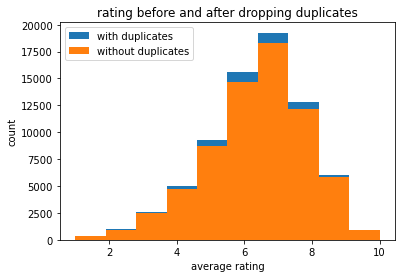

In [544]:
plt.hist(dfm_basics_rate.averagerating.values, label='with duplicates')
plt.hist(dfm_basics_rate.drop_duplicates(subset=['primary_title']).averagerating.values, label='without duplicates')
plt.title('rating before and after dropping duplicates')
plt.xlabel('average rating')
plt.ylabel('count')
plt.legend();

In [545]:
# drop duplicates on the primary title column
dfm_basics_rate.drop_duplicates(subset=['primary_title'], inplace=True)
dfm_basics_rate.shape

(69119, 7)

### Check for Missing Values
From the code below we see that movies missing runtime duration form 10% of the sample. To clean this, i will use the median runtime to fill in the missing data as it is least susceptible to outliers

The movies missing genres make up only 1% and are evenly distributed from lower to higher rating values. As such, I will drop all rows missing genres

In [546]:
# function to identify missing values
def missing_values(data):
    """A simple function to identify data has missing values"""
    # identify the total missing values per column
    # sort in order 
    miss = data.isnull().sum().sort_values(ascending = False)

    # calculate percentage of the missing values
    percentage_miss = (data.isnull().sum() / len(data) * 100).sort_values(ascending = False)

    # store in a dataframe 
    missing = pd.DataFrame({"Missing Values": miss, "Percentage(%)": percentage_miss})

    # remove values that are missing 
    missing.drop(missing[missing["Percentage(%)"] == 0].index, inplace = True)

    return missing

missing_values(dfm_basics_rate)

,Missing Values,Percentage(%)
runtime_minutes,7264,10.509411
genres,759,1.098106


The code below fills missing vauues of movie duration using the median runtime

In [547]:
# fill runtime missing values
dfm_basics_rate['runtime_minutes'] = dfm_basics_rate['runtime_minutes'].fillna(dfm_basics_rate['runtime_minutes'].median())
dfm_basics_rate[dfm_basics_rate.runtime_minutes.isnull()]

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes


The code below will drop movies rows missing genres

In [548]:
# drop genres missing values
dfm_basics_rate.genres.dropna(inplace=True)

When I check missing values on genres, they still exist. meaning the code did not work. For lack of time will move on.

In [549]:
missing_values(dfm_basics_rate)

,Missing Values,Percentage(%)
genres,759,1.098106


### Clean Genres Column
For some movies, the genres column contains multiple genres, which will make this messy to analyze, especially when trying to do value counts to determine the most common genres. For the rows with multiple genres, we split those across mutiple genre columns, so we will have genre1 with the first mentioned genre, etc. The code below does exactly that

In [550]:
genres_df = dfm_basics_rate['genres'].str.split(',', expand=True)
dfm_basics_rate = pd.concat([dfm_basics_rate, genres_df], axis=1)
dfm_basics_rate.rename(columns={0: 'genres1', 1: 'genres2', 2: 'genres3'}, inplace=True)
dfm_basics_rate.head()

,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes,genres1,genres2,genres3
0,tt0063540,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77,Action,Crime,Drama
1,tt0066787,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",7.2,43,Biography,Drama,None
2,tt0069049,The Other Side of the Wind,2018,122.0,Drama,6.9,4517,Drama,None,None
3,tt0069204,Sabse Bada Sukh,2018,91.0,"Comedy,Drama",6.1,13,Comedy,Drama,None
4,tt0100275,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",6.5,119,Comedy,Drama,Fantasy


### Movie Budgets Table
Having prepared the data above, we move on to the tn.movie_budgets.csv table. This movie contains crucial financial performance data that will enable us to assess the size of the industry by genres & studios, but will also let us know whether highly rated movies are profitable in the box office

Initial scan below shows:
- no missing values
- columns with financial performance data are encoded as string - these will need to be cleaned
- duplicated values in the id column. The column is of no value and will be deleted
- duplicated movie names. These will need to be investigated


In [551]:
# import the data
df_budgets_tn = pd.read_csv('tn.movie_budgets.csv')

# check for data properties
print(df_budgets_tn.info())
print('\n')

# check for dataframe row duplicates
print('dataframe row duplicates')
print(df_budgets_tn.duplicated().value_counts())
print('\n')

# check for col duplicates
print('row duplicates by column')
for output in [df_budgets_tn[col].duplicated().value_counts() for col in df_budgets_tn.columns]:
    print('\n')
    print(output)
    
df_budgets_tn.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB
None


dataframe row duplicates
False    5782
dtype: int64


row duplicates by column


True     5682
False     100
Name: id, dtype: int64


True     3364
False    2418
Name: release_date, dtype: int64


False    5698
True       84
Name: movie, dtype: int64


True     5273
False     509
Name: production_budget, dtype: int64


False    5164
True      618
Name: domestic_gross, dtype: int64


False    5356
True      426
Name: worldwide_gross, dtype: int64


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Transform Budget & Gross Columns
The code below transforms these columns to the appropriate type - numeric

In [553]:
df_budgets_tn['production_budget'] = pd.to_numeric(df_budgets_tn['production_budget'].str.replace(',', '').str.replace('$', ''))
df_budgets_tn['domestic_gross'] = pd.to_numeric(df_budgets_tn['domestic_gross'].str.replace(',', '').str.replace('$', ''))
df_budgets_tn['worldwide_gross'] = pd.to_numeric(df_budgets_tn['worldwide_gross'].str.replace(',', '').str.replace('$', ''))
df_budgets_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   int64 
 4   domestic_gross     5782 non-null   int64 
 5   worldwide_gross    5782 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 271.2+ KB


The id column doesn't have any usable information, so we drop it below

Next we inspect the values in production_budget, domestic_gross & worldwide_gross columns to ensure that they make sense. We see that the everage movie budget is $ 31.5 million. This is consistent with what [google](https://www.google.com/search?q=average+film+budget&client=firefox-b-d&biw=1696&bih=829&sxsrf=AJOqlzUgyL2f8lA_uN1IwozEJI9iVpZgSA%3A1678562942167&ei=ftYMZLjnCbPAlAaX46HQBw&oq=average+film&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQARgAMgUIABCRAjIKCAAQgAQQFBCHAjIFCAAQgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBQgAEIAEMgUILhCABDIFCAAQgAQyBQgAEIAEOgoIABBHENYEELADOgQILhAnOgQIIxAnOgUILhCRAjoLCC4QgwEQsQMQgAQ6CwgAEIAEELEDEIMBOgsILhCABBDHARDRAzoHCC4QsQMQQzoKCC4QxwEQ0QMQQzoKCC4Q1AIQsQMQQzoECC4QQzoKCC4QsQMQgwEQQzoECAAQQzoRCC4QgwEQrwEQxwEQsQMQgAQ6BwgAELEDEEM6CwguEIAEEMcBEK8BOggIABCABBDJAzoHCAAQgAQQCjoKCAAQgAQQyQMQCkoECEEYAFDXEFidMGDbQ2gBcAF4AIAB1gKIAYMbkgEFMi05LjOYAQCgAQHIAQjAAQE&sclient=gws-wiz-serp) says.

Some things to look into:
- some movies cost as little as $ 1,000 to make - need to verify this
- some movies are missing gross figures

In [576]:
df_budgets_tn.describe()

,production_budget,domestic_gross,worldwide_gross
count,5.782000e+03,5.782000e+03,5.782000e+03
mean,3.158776e+07,4.187333e+07,9.148746e+07
std,4.181208e+07,6.824060e+07,1.747200e+08
min,1.100000e+03,0.000000e+00,0.000000e+00
25%,5.000000e+06,1.429534e+06,4.125415e+06
50%,1.700000e+07,1.722594e+07,2.798445e+07
75%,4.000000e+07,5.234866e+07,9.764584e+07
max,4.250000e+08,9.366622e+08,2.776345e+09


The data below shows that the least expensive move cost $ 1,100 to make. [google](https://www.google.com/search?q=my+date+with+drew&client=firefox-b-d&sxsrf=AJOqlzUytflOu-wMZp2TdtTDurzpcVUsNg%3A1678617639497&ei=J6wNZMyDHs2ZkwXEtZSgAQ&gs_ssp=eJzj4tTP1Tcwt6xMMTVg9BLMrVRISSxJVSjPLMlQSClKLQcAhTYJbw&oq=My+Date+With+Drew&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQARgAMgUILhCABDIFCAAQgAQyBQgAEIAEMgUIABCABDIFCAAQgAQyBggAEBYQHjIGCAAQFhAeMgYIABAWEB4yCAgAEBYQHhAPMggIABAWEB4QDzoICAAQogQQsANKBAhBGAFQyoMFWMqDBWChmQVoAXAAeACAAeABiAHgAZIBAzItMZgBAKABAqABAcgBA8ABAQ&sclient=gws-wiz-serp) was able to verify this as true.

As a result, it did not make sense to delete data with such figures as it will skew the data and might misrepresent the market's financial performance

Below we also see movies like Red 11 missing gross earnings. For the lack of enough time, I will not focus on scraping data from the web to. This missing data accounts for only 9.4% of the total data, thus I will leave as is

In [587]:
# inspect low budget movies
df_budgets_tn[df_budgets_tn['production_budget'] < 31587760].tail(10)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
5772,"Jan 13, 2012",Newlyweds,9000,4584,4584
5773,"Feb 26, 1993",El Mariachi,7000,2040920,2041928
5774,"Oct 8, 2004",Primer,7000,424760,841926
5775,"May 26, 2006",Cavite,7000,70071,71644
5776,"Dec 31, 2004",The Mongol King,7000,900,900
5777,"Dec 31, 2018",Red 11,7000,0,0
5778,"Apr 2, 1999",Following,6000,48482,240495
5779,"Jul 13, 2005",Return to the Land of Wonders,5000,1338,1338
5780,"Sep 29, 2015",A Plague So Pleasant,1400,0,0
5781,"Aug 5, 2005",My Date With Drew,1100,181041,181041


In [586]:
# inspect movies with no gross earnings
gr = df_budgets_tn[df_budgets_tn['domestic_gross'] == 0].shape[0]
print(f'{gr} movies have no gross earnings. This is 9.4% of the data' )

548 movies have no gross earnings. This is 9.4% of the data


In [597]:
# drop id column as it has no value
df_budgets_tn.drop('id', axis=1, inplace=True)
df_budgets_tn.columns

### Handle Duplicate Names in Movie Column
A look at the duplicated movie names below show that the movies were released on different years, suggesting that the duplicates are movie remakes, eg.:
- 20,000 Leagues Under the Sea released in 1916 then in 1954
- A Nightmare on Elm Street in 1984 and in 2010

Since I intend to merge the data with other tables - dfm_basics_rate from sql & bom.movie_gross from csv - I will treat these as duplicates. I will only keep the most recent version of the movie

In [596]:
df_budgets_tn[df_budgets_tn.movie.duplicated(
                keep=False)].sort_values(by='movie', key=lambda x: x.str.lower()).head(10)

,release_date,movie,production_budget,domestic_gross,worldwide_gross
4270,"Dec 23, 1954","20,000 Leagues Under the Sea",5000000,28200000,28200000
5614,"Dec 24, 1916","20,000 Leagues Under the Sea",200000,8000000,8000000
1648,"Apr 30, 2010",A Nightmare on Elm Street,35000000,63075011,117729621
5016,"Nov 9, 1984",A Nightmare on Elm Street,1800000,25504513,25504513
2032,"Nov 11, 1992",Aladdin,28000000,217350219,504050219
80,"May 24, 2019",Aladdin,182000000,246734314,619234314
50,"Mar 5, 2010",Alice in Wonderland,200000000,334191110,1025491110
4759,"Jul 28, 1951",Alice in Wonderland,3000000,0,0
4120,"Oct 17, 1956",Around the World in 80 Days,6000000,42000000,42000000
340,"Jun 16, 2004",Around the World in 80 Days,110000000,24004159,72004159


In [560]:
# drop id column as it has no value
df_budgets_tn.drop('id', axis=1, inplace=True)
df_budgets_tn.columns

Index(['release_date', 'movie', 'production_budget', 'domestic_gross',
       'worldwide_gross'],
      dtype='object')

The code below will drop the duplicated movie names, retaining only those with the most recent release date

In [598]:
# Convert the 'release_date' column to a datetime format
df_budgets_tn['release_date'] = pd.to_datetime(df_budgets_tn['release_date'])

# Sort the DataFrame by the 'release_date' column in descending order
df_budgets_tn = df_budgets_tn.sort_values(by=['release_date'], ascending=False)

# Drop duplicates on the 'movie' column, keeping the first occurrence
df_budgets_tn = df_budgets_tn.drop_duplicates(subset='movie', keep='first')

# Reset the index of the DataFrame
df_budgets_tn = df_budgets_tn.reset_index(drop=True)

# Recheck the data for duplicated movie names
df_budgets_tn[df_budgets_tn.movie.duplicated(
                keep=False)].sort_values(by='movie', key=lambda x: x.str.lower()).head(10)

,release_date,movie,production_budget,domestic_gross,worldwide_gross


### Import Movie Gross Table
In the movie gross table, we are only interested in the title and studio columns. We will clean these 2 and merge them with the movie bugets table, to enable us get a wholistic performance upto studio level.

This table misses information on movie budget, which is crucial for assessing profitability of the movies and studios. Thus we are faced with 2 choices:
- scrape the web for that information for these particular movies
- join this table to the movie budgets table which already has this information
Because of time constraint, I will go with option 2 above. The code below imports the data:
- the data has 1 duplicate, however, this will be dropped when it is joined to the movie budget table as the movie doesn't exist in that table
- we have 5 missing studio names. However, we will save exploring these till we merge the data. This will save us time if they don't exist in the merge


In [600]:
# import data
df_gross_bom = pd.read_csv('bom.movie_gross.csv')

# check for data properties
print(df_gross_bom.info())
print('\n')

# check for dataframe row duplicates
print('dataframe row duplicates')
print(df_gross_bom.duplicated().value_counts())
print('\n')

# check for col duplicates
print('row duplicates by column')
for output in [df_gross_bom[col].duplicated().value_counts() for col in df_gross_bom.columns]:
    print('\n')
    print(output)

# preview data
df_gross_bom.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None


dataframe row duplicates
False    3387
dtype: int64


row duplicates by column


False    3386
True        1
Name: title, dtype: int64


True     3129
False     258
Name: studio, dtype: int64


False    1798
True     1589
Name: domestic_gross, dtype: int64


True     2182
False    1205
Name: foreign_gross, dtype: int64


True     3378
False       9
Name: year, dtype: int64


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


### Join Movie Budget Table to Movie Gross Table

In [617]:
# merge the 2 tables
df_budg_gros = pd.merge(df_budgets_tn, df_gross_bom, left_on='movie', right_on='title', how='inner')
print(f'merged data has {df_budg_gros.shape[0]} movies')
df_budg_gros.head()

merged data has 1238 movies


,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,title,studio,domestic_gross_y,foreign_gross,year
0,2018-12-25,Destroyer,9000000,1533324,3681096,Destroyer,Annapurna,1500000.0,4000000,2018
1,2018-12-25,Vice,60000000,47836282,70883171,Vice,Annapurna,47800000.0,28200000,2018
2,2018-12-25,On the Basis of Sex,20000000,24622687,38073377,On the Basis of Sex,Focus,24600000.0,13600000,2018
3,2018-12-21,Aquaman,160000000,335061807,1146894640,Aquaman,WB,335100000.0,812700000,2018
4,2018-12-21,Second Act,15700000,39282227,63288854,Second Act,STX,39300000.0,33000000,2018


In [652]:
# drop unnecessary columns
df_budg_gros.drop(['release_date', 'domestic_gross_y', 'foreign_gross', 'title'], axis=1, inplace=True)
df_budg_gros.head(3)

,movie,production_budget,domestic_gross_x,worldwide_gross,studio,year
0,Destroyer,9000000,1533324,3681096,Annapurna,2018
1,Vice,60000000,47836282,70883171,Annapurna,2018
2,On the Basis of Sex,20000000,24622687,38073377,Focus,2018


In [651]:
# check for any duplicated movie names
print(df_budg_gros.movie.duplicated().value_counts())

False    1238
Name: movie, dtype: int64


In [630]:
# select missing studio
df_budg_gros[df_budg_gros.studio.isnull()]

,release_date,movie,production_budget,domestic_gross_x,worldwide_gross,title,studio,domestic_gross_y,foreign_gross,year
927,2011-10-14,Fireflies in the Garden,8000000,36884,3587191,Fireflies in the Garden,NaN,70600.0,3300000,2011


Online search shows that the movie [Fireflies in the Garden](https://www.google.com/search?q=Fireflies+in+the+Garden+2011&client=firefox-b-d&ei=Z-kNZN-zFc_tkgW9t62ADg&ved=2ahUKEwj5_5vG1Nb9AhXSt6QKHf5VDOIQnZMFKAZ6BAhxEBo&uact=5&oq=Fireflies+in+the+Garden+2011&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQAzIFCCEQoAEyBQghEKABOgoIABBHENYEELADOgcIABCwAxBDOg0IABDkAhDWBBCwAxgBOgwILhDIAxCwAxBDGAI6DwguENQCEMgDELADEEMYAjoFCAAQgAQ6BQguEIAEOgYIABAWEB5KBAhBGABQ3ApYmTlgpUhoAXABeACAAf0BiAGACZIBAzItNZgBAKABAcgBEMABAdoBBggBEAEYCdoBBggCEAEYCA&sclient=gws-wiz-serp&si=AEcPFx4nNhdW24McLJnO3wz0yM2YS0v8Ci80mwVWMos91fJ87d_cQUzWzp1DK1Ctuh5EL7zxjXgy4ceJbMw-ehDtYENcJT2DQHipsA-rfVo-0rVE3_q4i2SwXgf-ZQTuZUKCd_KFpNi0&ictx=1) is affiliated with universal studios

In [653]:
# Replace missing studio
df_budg_gros['studio'].fillna('Uni.', inplace=True)
df_budg_gros[df_budg_gros.movie == 'Fireflies in the Garden']

,movie,production_budget,domestic_gross_x,worldwide_gross,studio,year
927,Fireflies in the Garden,8000000,36884,3587191,Uni.,2011


### Save Cleaned Data For Report Writing
The code below will save the following data which we have modified to csv. I will import these in the analysis and reporting notebook:
- dfm_basics_rate: cleaned data that is a merge of the ‘movie_basics’ & ‘movie_ratings’ tables from the im.db sql database
- df_budgets_tn: cleaned data of the ‘tn.movie_budgets.csv’
- df_budg_gros: cleaned data that is a merged of the ‘tn.movie_budgets.csv’ & 'bom.movie_gross.csv'

In [642]:
# dfm_basics_rate to csv
dfm_basics_rate.to_csv('dfm_basics_rate.csv', index=False, encoding='utf-8')

In [643]:
# df_budgets_tn to csv
df_budgets_tn.to_csv('df_budgets_tn.csv', index=False, encoding='utf-8')

In [654]:
# df_budg_gros to csv
df_budg_gros.to_csv('df_budg_gros.csv', index=False, encoding='utf-8')

### Persons Table
This table contains "primary_name" column which will be important especially when we start to look at top performing movies to answer the questions like who are their main actors, or who directed these movies, to see if there is a common pattern of stars and directors that feature in top performing movies. Thus we will look at keeping this column. We will not keep "primary_profession" column since it has multiple values for each person, and we can get pretty much the same information from
categories in the principals table

Below output shows that our columns of interest "person_id" & "primary_name" don't have missing values

In [27]:
# open the persons table

m_basics = """
SELECT *
   FROM persons;
"""
df_persons = pd.read_sql(m_basics, conn)

# we will focus exploration on columns of
#interest i.e "person_id" & "primary_name"
print(df_persons.info())
print('\n')
print([df_persons.isnull().any()])

# preview the first 5 rows
df_persons.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606648 entries, 0 to 606647
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   person_id           606648 non-null  object 
 1   primary_name        606648 non-null  object 
 2   birth_year          82736 non-null   float64
 3   death_year          6783 non-null    float64
 4   primary_profession  555308 non-null  object 
dtypes: float64(2), object(3)
memory usage: 23.1+ MB
None


[person_id             False
primary_name          False
birth_year             True
death_year             True
primary_profession     True
dtype: bool]


,person_id,primary_name,birth_year,death_year,primary_profession
0,nm0061671,Mary Ellen Bauder,NaN,NaN,"miscellaneous,production_manager,producer"
1,nm0061865,Joseph Bauer,NaN,NaN,"composer,music_department,sound_department"
2,nm0062070,Bruce Baum,NaN,NaN,"miscellaneous,actor,writer"
3,nm0062195,Axel Baumann,NaN,NaN,"camera_department,cinematographer,art_department"
4,nm0062798,Pete Baxter,NaN,NaN,"production_designer,art_department,set_decorator"


### Check for Duplicates
When we check for duplicates below, we realise that primary names have duplicates, but "person_id" don't. This means that we may have some people with the same names, and can therefore only be distinguised by their "person_id"

In [9]:
# check for duplicates
print('primary name')
print(df_persons.primary_name.duplicated().value_counts())
print('\n')
print('person id')
print(df_persons.person_id.duplicated().value_counts())

primary name
False    577203
True      29445
Name: primary_name, dtype: int64


person id
False    606648
Name: person_id, dtype: int64


However, since we lack more context on the data, and how the "person_id" relates to "primary_name" it is also difficult to tell whether the duplicates below belong to the same person, since the database would have been compiled over a long period of time. In that case it would be possible for a person to be added to the database at different time periods with different "person_id" 

When I join this table to the movie basics table, I will make some assumptions to enable me identify "actual" duplicates. e.g. if we have the same primary name appearing more than once in a movie, then those are likely to be duplicates

See below a dataframe of all duplicated primary names

In [28]:
df_persons[df_persons.primary_name.duplicated(keep=False)].sort_values(by='primary_name', key=lambda x: x.str.lower()).head(10)

,person_id,primary_name,birth_year,death_year,primary_profession
279631,nm4062141,A. Venkatesh,NaN,NaN,"director,actor,writer"
156216,nm1701176,A. Venkatesh,NaN,NaN,"cinematographer,camera_department,editor"
129377,nm10275444,A. Venkatesh,NaN,NaN,director
387377,nm8956236,A. Venkatesh,NaN,NaN,producer
436444,nm6758318,A.J. Khan,NaN,NaN,producer
30159,nm0451160,A.J. Khan,1977.0,NaN,"actress,make_up_department,director"
565680,nm7645047,A.K. Azad,NaN,NaN,"music_department,composer"
398340,nm8244210,A.K. Azad,NaN,NaN,actor
262683,nm3942577,Aadhi,NaN,NaN,"actor,music_department,soundtrack"
446609,nm6832961,Aadhi,NaN,NaN,actor


### Principals Table
This table contains a useful column "category", which describes the roles/profession of each person in a film. Joining this to "primary_name" column from persons table will help us do away with the "primary_profession" column, which is messy

The table, by design has duplicated values for all columns, since it shows all cast members that appeared in each movie. As a result, since each person is likely to have participated in more than one movie, and each movie has more than one cast member

However, there is a possibility that we have multiple movie id's belonging to the same movie (due to different versions accounting for language etc), so we will address that when we join this table to movie basics, which contains the original movie ids & titles, thus any invalid duplicates will be visible then


In [13]:
# open the principals table

principals = """
SELECT *
   FROM principals;
"""
df_principals = pd.read_sql(principals, conn)

# check for dataframe row duplicates
print('check for dataframe row duplicates')
print(df_principals.duplicated().value_counts())
print('\n')

# check for col row duplicates
print('check for column row duplicates')
for output in [df_principals[col].duplicated().value_counts() for col in df_principals.columns]:
    print(output)
    print('\n')

# check for missing values
print('check for missing values')
print(df_principals.isnull().any())

# preview the first 5 rows
df_principals.head()

check for dataframe row duplicates
False    1028186
dtype: int64


check for column row duplicates
True     884732
False    143454
Name: movie_id, dtype: int64


True     1028176
False         10
Name: ordering, dtype: int64


False    604546
True     423640
Name: person_id, dtype: int64


True     1028174
False         12
Name: category, dtype: int64


True     1025220
False       2966
Name: job, dtype: int64


True     853423
False    174763
Name: characters, dtype: int64


check for missing values
movie_id      False
ordering      False
person_id     False
category      False
job            True
characters     True
dtype: bool


,movie_id,ordering,person_id,category,job,characters
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]"
1,tt0111414,2,nm0398271,director,None,None
2,tt0111414,3,nm3739909,producer,producer,None
3,tt0323808,10,nm0059247,editor,None,None
4,tt0323808,1,nm3579312,actress,None,"[""Beth Boothby""]"


The output below shows that the actor nm9861411 appeared 4 different movies as "The Noob". This reinforces the above point of the same movie having different versions - highly unlikely that the same actor would be cast as "The Noob" in 4 different unrelated movies

In [31]:
df_principals[df_principals['person_id'] == 'nm9861411']

,movie_id,ordering,person_id,category,job,characters
878454,tt8574528,1,nm9861411,actor,None,"[""The Noob""]"
1013101,tt8469414,1,nm9861411,actor,None,"[""The Noob""]"
1013231,tt8525414,1,nm9861411,actor,None,"[""The Noob""]"
1017079,tt8479986,1,nm9861411,actor,None,"[""The Noob""]"


Each cast member is likely to have appeared in more than one movie, as highlighted by the example below

In [30]:
df_principals[df_principals['person_id'] == 'nm1930572'].head(10)

,movie_id,ordering,person_id,category,job,characters
7271,tt1801509,3,nm1930572,composer,None,None
16466,tt1805164,9,nm1930572,composer,None,None
20175,tt1607598,8,nm1930572,composer,None,None
24791,tt1620748,7,nm1930572,composer,None,None
29594,tt1596776,7,nm1930572,composer,None,None
30782,tt1930355,7,nm1930572,composer,None,None
32106,tt2178300,6,nm1930572,composer,None,None
33904,tt1603386,7,nm1930572,composer,composer,None
36325,tt2099628,6,nm1930572,composer,None,None
39502,tt1723736,6,nm1930572,composer,None,None


From the 2 outputs below, we see that that the ordering column ranks all cast members in a movie in some particular order. The ranks are not consistent across movies as shown by the 2 examples below, but the actors are ranked higher than the other cast members

In [15]:
df_principals[df_principals['movie_id'] == 'tt8525414']

,movie_id,ordering,person_id,category,job,characters
1013231,tt8525414,1,nm9861411,actor,None,"[""The Noob""]"
1013232,tt8525414,2,nm1930572,composer,None,None
1013233,tt8525414,3,nm3635913,composer,None,None


In [33]:
df_principals[df_principals['movie_id'] == 'tt0837562']

,movie_id,ordering,person_id,category,job,characters
218624,tt0837562,10,nm1156984,writer,story by,None
218625,tt0837562,1,nm0001191,actor,None,"[""Dracula""]"
218626,tt0837562,2,nm0416673,actor,None,"[""Frankenstein""]"
218627,tt0837562,3,nm1676221,actor,None,"[""Jonathan""]"
218628,tt0837562,4,nm1411125,actress,None,"[""Mavis""]"
218629,tt0837562,5,nm0850733,director,None,None
218630,tt0837562,6,nm0063165,writer,screenplay by,None
218631,tt0837562,7,nm0806912,writer,screenplay by,None
218632,tt0837562,8,nm0244110,writer,story by,None
218633,tt0837562,9,nm1087952,writer,story by,None


In [655]:
conn.close()